## Land Eligibility for Wind Turbines

(a) Import the relevant packages needed to perform this analysis.

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from rasterio.plot import show
from atlite.gis import ExclusionContainer, shape_availability

(b) Translate the CORINE land classes listed above to code values as stored in the dataset using the table above. Also state the descriptive names of the classes. Distinguish between classes to which a distance should be kept and classes deemed eligible for wind development.

Classes to which a distance should be kept:

Classes: 111, 112, 121, 122, 123, 124
Descriptive names: Continuous urban fabric, Discontinuous urban fabric, Industrial or commercial units, Road and rail networks and associated land, Port areas, Airports

Classes deemed eligible for wind development:

Classes: 211, 212, 213, 231, 241, 242, 243, 321, 323, 324, 333
Descriptive names: Non-irrigated arable land, Permanently irrigated land, Rice fields, Vineyards, Fruit trees and berry plantations, Olive groves, Pastures, Transitional woodland/shrub, Other wooded land, Natural grassland, Moors and heathland

(c) Load the country shapes as GeoDataFrame, reduce it to a single entry for Luxembourg, and reproject it to EPSG:3035.

In [2]:
csv = "country_shapes.geojson"
countries = gpd.read_file(csv).set_index('name')

In [3]:
clc = rasterio.open('https://tubcloud.tu-berlin.de/s/z7aY8HNCdETQMT7/download/U2018_CLC2018_V2020_20u1-LU.tif')
band = clc.read(1)
band

array([[-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       ...,
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128]], dtype=int8)

C:\Users\Shahzaib Khan\miniconda3\envs\energy\Lib\site-packages\geopandas\geoseries.py:720: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


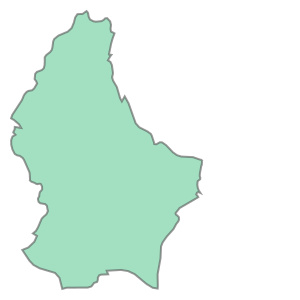

In [4]:
excluder = ExclusionContainer(crs=3035)
shape = countries.to_crs(excluder.crs).loc[["LU"]].geometry
shape[0]

(d) Plot and calculate (in %) the area excluded by each of the exclusion constraints (1.-6.) individually using the atlite.gis.ExclusionContainer and atlite.gis.shape_availability. Refer to the atlite tutorial for information on how to plot the output of the latter function with rasterio and matplotlib

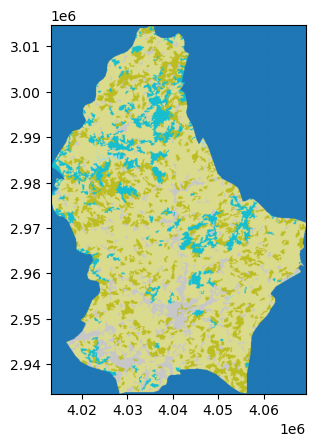

<Axes: >

In [6]:
show(band, transform=clc.transform, cmap='tab20')

Continuous urban fabric: 25.13% excluded
Discontinuous urban fabric: 66.40% excluded
Industrial or commercial units: 40.15% excluded
Road and rail networks: 24.19% excluded
Port areas: 64.53% excluded
Airports: 37.67% excluded


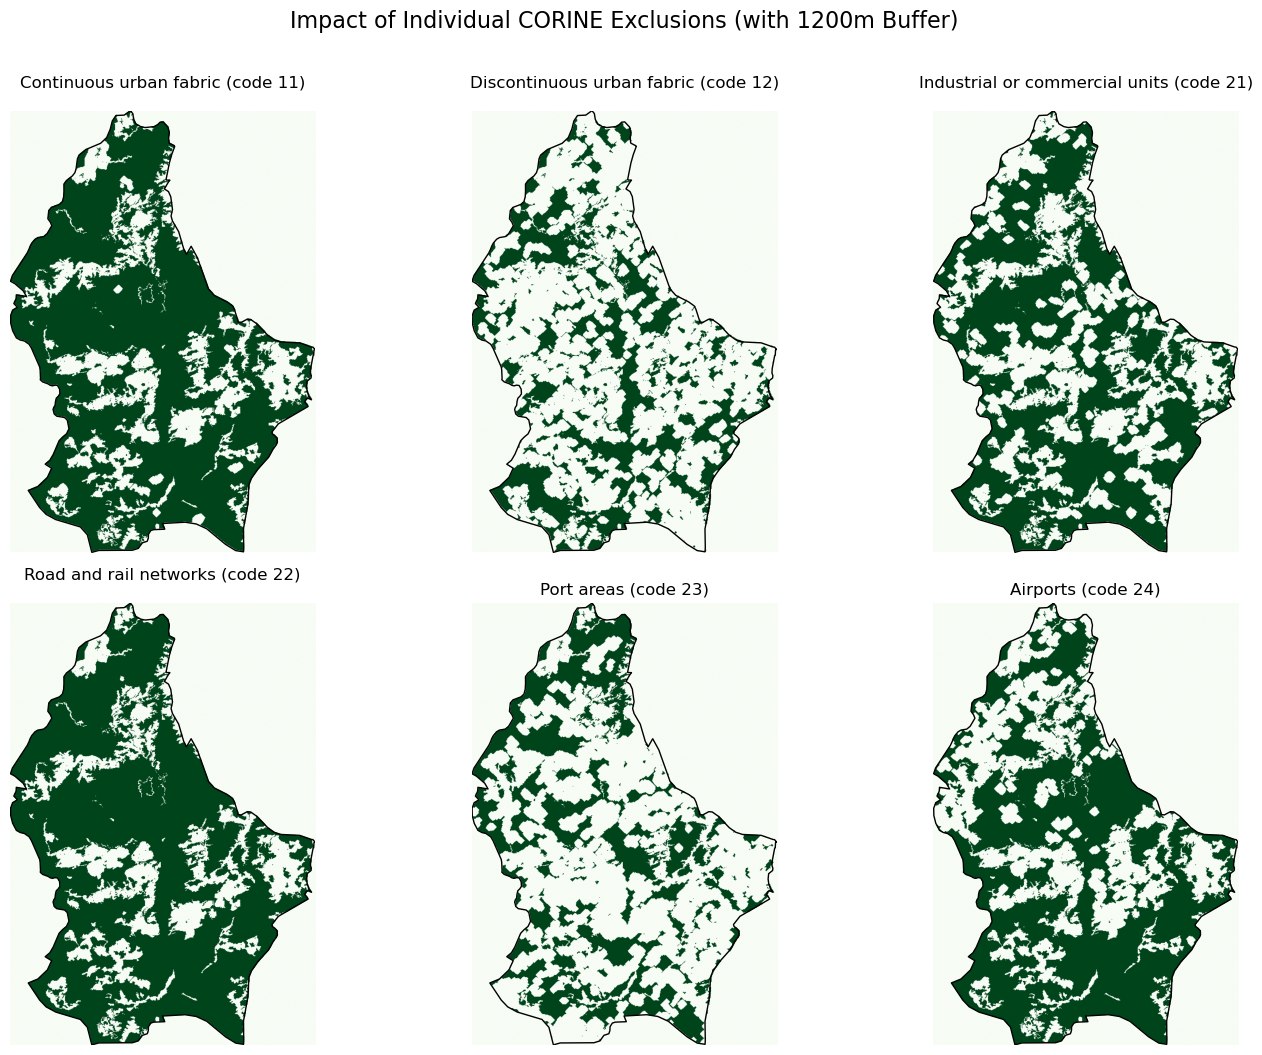

In [38]:
# CORINE raster file
fn = 'U2018_CLC2018_V2020_20u1-LU.tif'

# Individual exclusion codes (grouped by conceptual similarity, you can split differently)
corine_exclusions = {
    11: "Continuous urban fabric",
    12: "Discontinuous urban fabric",
    21: "Industrial or commercial units",
    22: "Road and rail networks",
    23: "Port areas",
    24: "Airports"
}

# Country shape (Luxembourg), assumed already defined and reprojected
# luxembourg = countries.loc[["LU"]].to_crs(3035)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Loop through each exclusion code
for i, (code, label) in enumerate(corine_exclusions.items()):
    # Create exclusion container
    ex = ExclusionContainer(crs=3035)
    ex.add_raster(fn, codes=[code], buffer=400, crs=3035)
    ex.add_geometry('Natura2000_end2021-LU.gpkg')
    # Calculate availability
    band, transform = shape_availability(luxembourg, ex)
    
    # Plot
    ax = axes[i]
    luxembourg.plot(ax=ax, color='none', edgecolor='black')
    show(band, transform=transform, ax=ax, cmap='Greens')
    ax.set_title(f"{label} (code {code})")
    ax.axis('off')
    
    # Calculate and print excluded area %
    eligible_cells = band.sum()
    cell_area = ex.res ** 2
    eligible_area = eligible_cells * cell_area
    country_area = luxembourg.geometry.area.sum()
    exclusion_pct = 100 - (eligible_area / country_area * 100)
    print(f"{label}: {exclusion_pct:.2f}% excluded")

# Hide unused subplots if any
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Impact of Individual CORINE Exclusions (with 1200m Buffer)", fontsize=16, y=1.05)
plt.show()


(e) Plot and calculate (in %) the area available for the development of wind parks considering all exclusion zones together?

In [10]:
fn = 'U2018_CLC2018_V2020_20u1-LU.tif'
codes = [12, 13, 14, 18, 19, 20, 21, 26, 28, 29, 32]
excluder.add_raster(fn, codes=codes, crs=3035, invert=True)

In [11]:
codes = [1, 2, 3, 4, 5 ,6]

In [12]:
excluder.add_raster(fn, codes=codes, buffer=1200, crs=3035)

<Axes: >

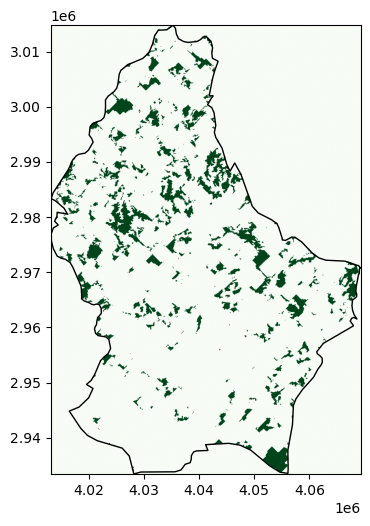

In [13]:
band, transform = shape_availability(shape, excluder)

fig, ax = plt.subplots(figsize=(4,8))
shape.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)

In [14]:
eligible_cells = band.sum()
cell_area = excluder.res**2
eligible_area = cell_area * eligible_cells
country_area = shape.geometry.area[0]
total_eligible_area = eligible_area / country_area * 100
total_exclusion_area = 100 - total_eligible_area
print ('Total eligible area for development of wind parks is', total_eligible_area.round(3), '%')
print ('Total exclusion area is', total_exclusion_area.round(3), '%')

Total eligible area for development of wind parks is 11.667 %
Total exclusion area is 88.333 %


C:\Users\Shahzaib Khan\AppData\Local\Temp\ipykernel_5424\292097413.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  country_area = shape.geometry.area[0]


(g) Perform a sensitivity analysis on the distance criterion to CORINE land classes by repeating the land eligibility calculation with distance requirements of 0m, 200m, 400m, 600m, 800m and 1000m. Plot the available area as a function of the distance requirements and describe the curve. Make sure to label your figure appropriately

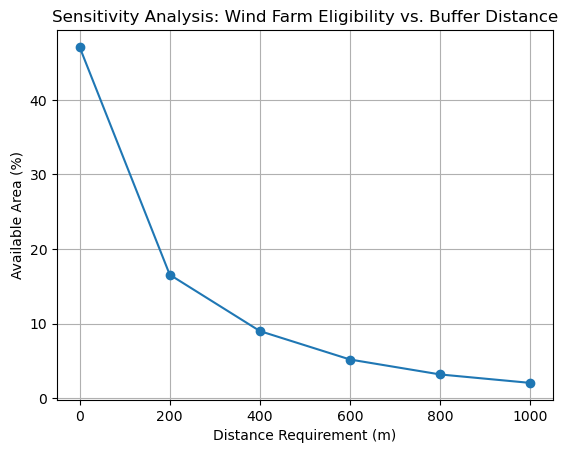

In [30]:
from atlite.gis import ExclusionContainer, shape_availability

distance_requirements = [0, 200, 400, 600, 800, 1000]
available_area = []

# Load shape for Luxembourg
luxembourg = countries.loc[["LU"]].to_crs(3035).geometry

for distance in distance_requirements:
    # Fresh exclusion container each time to reset buffer
    corine_exclusions = ExclusionContainer(crs=3035)
    corine_exclusions.add_raster(
        "U2018_CLC2018_V2020_20u1-LU.tif",
        codes=[12, 13, 14, 18, 19, 20, 21, 26, 28, 29, 32],
        buffer=distance,
        crs=3035
    )
    
    band, _ = shape_availability(luxembourg, corine_exclusions)
    eligible_cells = band.sum()
    cell_area = corine_exclusions.res ** 2
    eligible_area = eligible_cells * cell_area
    country_area = luxembourg.geometry.area.sum()
    
    area_pct = (eligible_area / country_area) * 100
    available_area.append(area_pct)

# Plot
plt.plot(distance_requirements, available_area, marker='o')
plt.xlabel("Distance Requirement (m)")
plt.ylabel("Available Area (%)")
plt.title("Sensitivity Analysis: Wind Farm Eligibility vs. Buffer Distance")
plt.grid(True)
plt.show()


(h) Assume that for the expansion of wind power in Luxembourg, a capacity density of 2 MW/km 2 of available land can be achieved and that the wind conditions result in an average capacity factor of 33%. What is the total energy in units of TWh that could be produced from wind power in Luxembourg each year if the distance criterion were reduced to 800m?

In [39]:
# Define base parameters
distance = 800  # Buffer distance for CORINE exclusions
capacity_density = 2  # MW/km²
capacity_factor = 0.33  # 33%
country_area_km2 = luxembourg.geometry.area.sum() / 1e6  # Convert from m² to km²

# --- Define exclusion container ---
ex = ExclusionContainer(crs=3035)

# 1. CORINE eligible land classes to be excluded with 800m buffer
corine_exclusion_codes = [111, 112, 121, 122, 123, 124]  # Urban fabric, industry, transport, ports, airports
ex.add_raster('U2018_CLC2018_V2020_20u1-LU.tif', codes=corine_exclusion_codes, buffer=distance, crs=3035)

# 2. Add other exclusions (geometry-based)
ex.add_geometry('Natura2000_end2021-LU.gpkg')     # Natura2000
ex.add_geometry('CDDA_2022_v01_public-LU.gpkg')           # CDDA
ex.add_geometry('ne_10m_airports.gpkg', buffer=1000)  # Airports
ex.add_geometry('ne_10m_roads.gpkg', buffer=200)      # Roads

# 3. Run availability check
band, _ = shape_availability(luxembourg, ex)

# 4. Calculate available area
cell_area_km2 = ex.res ** 2 / 1e6
available_cells = band.sum()
available_area_km2 = available_cells * cell_area_km2
available_area_pct = (available_area_km2 / country_area_km2) * 100

# 5. Estimate annual energy generation
total_energy_TWh = available_area_km2 * capacity_density * capacity_factor / 1000

# 6. Print results
print(f"Available area for wind: {available_area_km2:.2f} km² ({available_area_pct:.2f}%)")
print(f"Estimated annual wind energy potential: {total_energy_TWh:.3f} TWh")


Available area for wind: 1195.69 km² (45.84%)
Estimated annual wind energy potential: 0.789 TWh
